# Вебинар 6. Двухуровневые модели рекомендаций


### Зачем 2 уровня?
- Классические модели классификации (lightgbm) зачастую работают лучше, чем рекоммендательные модели (als, lightfm)
- Данных много, предсказаний много (# items * # users) --> с таким объемом lightgbm не справляется
- Но рекомендательные модели справляются!

Отбираем top-N (200) *кандидатов* с помощью простой модели (als) --> переранжируем их сложной моделью (lightgbm)
и выберем top-k (10).

---

### Применение в бизнесе

Если вы еще не прочитали [статью](https://habr.com/ru/company/hh/blog/347276/) о рекомендательных системах и поиске в hh.ru, то обязательно прочитайте

- 2-ух уровневая система применяется во многих компаниях
- Зачастую уровней > 2
- Идем от более простых эвристик/моделей к более сложным
- Фичи из моделей первого уровня (embeddings, biases из ALS) можно использовать в последующих моделях

Также решения на основе 2-ух уровневых рекомендаций заняли все топ-10 мест в соревновании X5 Retail hero.

- [Презентация](https://github.com/aprotopopov/retailhero_recommender/blob/master/slides/retailhero_recommender.pdf) и [Код](https://github.com/aprotopopov/retailhero_recommender) решения 2-ого места
- [Код](https://vk.com/away.php?utf=1&to=https%3A%2F%2Fgithub.com%2Fmike-chesnokov%2Fx5_retailhero_2020_recs) решения 9-ого места

![hh_recsys.png](attachment:hh_recsys.png)

### Как отбирать кандидатов?

Вариантов множество. Тут нам поможет *MainRecommender*. Пока в нем реализованы далеко не все возможные способы генерации кандидатов

- Генерируем топ-k кандидатов
- Качество кандидатов измеряем через **recall@k**
- recall@k показывает какую долю из купленных товаров мы смогли выявить (рекомендовать) нашей моделью

----

# Практическая часть

Код для src, utils, metrics вы можете скачать с [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [8]:
!pip install lightfm
!pip install implicit

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
sys.path.append('/content/drive/MyDrive/Rec_systems')
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [12]:
data = pd.read_csv('/content/drive/MyDrive/Rec_systems/retail_train.csv')
item_features = pd.read_csv('/content/drive/MyDrive/Rec_systems/product.csv')
user_features = pd.read_csv('/content/drive/MyDrive/Rec_systems/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель --
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [13]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [14]:
param_grid = {
              # 'n_factors': [10, 20, 30],
              # 'regularization': [0.01, 0.05, 0.001],
              # 'iterations':[5, 10, 15],
              'n_factors': [10, 20],
              'num_threads': [0]
              }

# params_df = pd.DataFrame([], columns=['n_factors', 'regularization', 'iterations', 'num_threads', 'recall_value'])
params_df = pd.DataFrame([], columns=['n_factors', 'num_threads', 'recall_value'])

keys, values = zip(*param_grid.items())
for v in itertools.product(*values):
    params = dict(zip(keys, v))
    recommender = MainRecommender(data_train_lvl_1, model_attrs=params)
    params['recall_value'] = round(recommender.get_recall_at_k(data_val_lvl_1, k=5), 4)
    print(params)
    params_df = params_df.append(params, ignore_index=True)

  0%|          | 0/5001 [00:00<?, ?it/s]

{'n_factors': 10, 'num_threads': 0, 'recall_value': 0.0201}


<ipython-input-14-0e97161e9376>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params_df = params_df.append(params, ignore_index=True)


  0%|          | 0/5001 [00:00<?, ?it/s]

{'n_factors': 20, 'num_threads': 0, 'recall_value': 0.0196}


<ipython-input-14-0e97161e9376>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params_df = params_df.append(params, ignore_index=True)


In [15]:
params_df

,n_factors,num_threads,recall_value
0,10.0,0.0,0.0201
1,20.0,0.0,0.0196


In [16]:
lvl_1_recommender = MainRecommender(data_train_lvl_1,
                              model_attrs=params_df.sort_values(by='recall_value', ascending=False).drop(columns=['recall_value']).to_dict(orient='records')[0])

  0%|          | 0/5001 [00:00<?, ?it/s]

### Варианты, как получить кандидатов

Можно потом все эти варианты соединить в один

(!) Если модель рекомендует < N товаров, то рекомендации дополняются топ-популярными товарами до N

In [17]:
test_user = 2375

In [18]:
recommender.get_als_recommendations(test_user, N=5)

[1106523, 1029743, 1044078, 899624, 844179]

In [19]:
recommender.get_own_recommendations(test_user, N=5)

[1029743, 1106523, 5569230, 916122, 844179]

In [20]:
recommender.get_similar_items_recommendation(test_user, N=5)

[1046545, 5565612, 823990, 974204, 15778319]

In [21]:
recommender.get_similar_users_recommendation(test_user, N=5)

[1029743, 1029743, 1029743, 1029743, 1029743]

### Измеряем recall@k

Это будет в ДЗ:

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [22]:
print(lvl_1_recommender.get_recall_at_k(data_val_lvl_1, k=50))
print(lvl_1_recommender.get_own_recall_at_k(data_val_lvl_1, k=50))

0.06283642225696066
0.0432368435310526


Cвязка own_recommendations + top показывает себя хуже по полноте, чем модель. Это не слишком логично и я ожидал другого результата, возможно в расчётах ошибка.

In [23]:
import matplotlib.pyplot as plt

k_list = pd.DataFrame([20, 50, 100, 200, 500])

k_list.columns = ['k']

In [24]:
k_list['recall'] = k_list.apply(lambda x: lvl_1_recommender.get_recall_at_k(data_val_lvl_1, k=x['k']), axis=1)

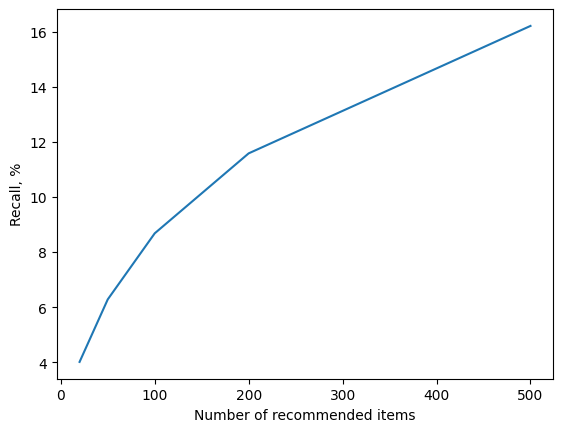

In [25]:
plt.plot(k_list['k'], k_list['recall']*100)
plt.xlabel('Number of recommended items')
plt.ylabel('Recall, %')
plt.show()

Полнота увеличивается с ростом количества рекоммендуемых объектов. Чем больше мы предлагаем, тем выше шанс, что мы угадаем предмет, который купил пользователь.

Если бы это была одноуровневая модель, то К должен быть той же размерности, что в итоге будет видеть пользователь. Если модель двухуровневая, то К должен быть максимально большой при разумном времени обучения второй модели.

### Обучаем модель 2-ого уровня на выбранных кандидатах

- Обучаем на data_train_lvl_2
- Обучаем *только* на выбранных кандидатах
- Я *для примера* сгенерирую топ-50 кадидиатов через get_own_recommendations
- (!) Если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [46]:
class LGBMRecommender():
  def __init__(self, data, candidates, user_features, item_features):

    self.data = data
    self.candidates = candidates
    self.user_features = user_features
    self.item_features = item_features

    self.X_train, self.y_train = self._prepare_dataset(self.data, self.candidates)

    self.cat_feats = self.X_train.columns[2:].tolist()
    self.X_train[self.cat_feats] = self.X_train[self.cat_feats].astype('category')
    self.model = self.fit(self.X_train, self.y_train, self.cat_feats)

  def _prepare_dataset(self, data, candidates):
    s = candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'item_id'
    candidates = candidates.drop('candidates', axis=1).join(s)

    targets = data.groupby(['user_id','item_id']).first().copy() # убираем дубликаты сочетаний user-item
    targets['target'] = 1  # тут только покупки

    targets = candidates.merge(targets, on=['user_id', 'item_id'], how='left')

    targets['target'].fillna(0, inplace= True)
    targets = targets.merge(self.item_features, on='item_id', how='left')
    targets = targets.merge(self.user_features, on='user_id', how='left')

    #Добавляем новые фичи
    targets = targets.merge(targets.groupby(['user_id', 'commodity_desc'])['sales_value'].mean().rename('mean_commodity_value').reset_index(), on=['user_id','commodity_desc'], how='left')
    targets = targets.merge(targets.groupby(['user_id', 'manufacturer'])['quantity'].mean().rename('mean_manufacturer_value').reset_index(), on=['user_id','manufacturer'], how='left')
    targets = targets.merge(targets.groupby(['week_no', 'item_id'])['sales_value'].mean().rename('mean_week_value').reset_index(), on=['week_no','item_id'], how='left')
    targets = targets.merge(targets.groupby(['store_id', 'item_id'])['sales_value'].mean().rename('mean_store_value').reset_index(), on=['store_id', 'item_id'], how='left')
    targets = targets.merge(targets.groupby(['user_id', 'basket_id'])['sales_value'].mean().rename('mean_basket_value').reset_index(), on=['user_id','basket_id'], how='left')
    targets = targets.merge(targets.groupby('user_id')['sales_value'].mean().rename('mean_check').reset_index(), how='left', on='user_id')

    X_train = targets.drop('target', axis=1)
    y_train = targets[['target']]

    return X_train, y_train

  @staticmethod
  def fit(X_train, y_train, cat_feats):
    model = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
    model.fit(X_train, y_train)
    return model

  def _get_recommendations(self, data, user_id, N=5):
    one_user = data[(data['user_id'] == user_id)]
    one_user['preds'] = self.model.predict_proba(data[(data['user_id'] == user_id)])[:,1]
    one_user = one_user[['item_id', 'preds']]
    recs = one_user.sort_values(by='preds', ascending=False)[:N]['item_id'].tolist()
    return recs

  def get_recall_at_k(self, val_data, candidates, k=5):
    val_data = self._prepare_dataset(val_data, candidates)[0]
    result = val_data.groupby('user_id')['item_id'].unique().reset_index()
    result.columns=['user_id', 'actual']
    result = result[result['user_id'].isin(self.data['user_id'])]
    result['pred'] = result.apply(lambda x: self._get_recommendations(self.X_train, x['user_id'], N=k), axis=1)
    recall_value = result.apply(lambda x: recall_at_k(x['pred'], x['actual'], k=k), axis=1).mean()

    return recall_value

  def get_precision_at_k(self, val_data, candidates, k=5):
    val_data = self._prepare_dataset(val_data, candidates)[0]
    result = val_data.groupby('user_id')['item_id'].unique().reset_index()
    result.columns=['user_id', 'actual']
    result = result[result['user_id'].isin(self.data['user_id'])]
    result['pred'] = result.apply(lambda x: self._get_recommendations(self.X_train, x['user_id'], N=k), axis=1)
    recall_value = result.apply(lambda x: precision_at_k(x['pred'], x['actual'], k=k), axis=1).mean()

    return recall_value

In [47]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
users_lvl_1 = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(users_lvl_1)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [48]:
val_users_lvl_2 = pd.DataFrame(data_val_lvl_2['user_id'].unique())
val_users_lvl_2.columns = ['user_id']

val_users_lvl_2 = val_users_lvl_2[val_users_lvl_2['user_id'].isin(users_lvl_1)]

val_users_lvl_2['candidates'] = val_users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [49]:
lvl_2_recommender = LGBMRecommender(data_train_lvl_2, users_lvl_2, user_features, item_features)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [50]:
lvl_2_recommender._get_recommendations(lvl_2_recommender.X_train, 255, N=10)

<ipython-input-46-e4ff75d6d50b>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_user['preds'] = self.model.predict_proba(data[(data['user_id'] == user_id)])[:,1]


[940947,
 899624,
 901062,
 908318,
 933835,
 916122,
 854405,
 844179,
 823704,
 834117]

In [45]:
data_val_lvl_2.groupby(['user_id','item_id']).first()

basket_id  day  quantity  sales_value  store_id  \
user_id item_id                                                       
1       821867    41338185846  639         1         0.69       436   
        834484    41338185846  639         1         0.50       436   
        856942    41338185846  639         1         2.99       436   
        861272    41613756353  660         1         0.69       436   
        865456    41338185846  639         1         3.99       436   
...                       ...  ...       ...          ...       ...   
2500    15831426  41324519561  638         1         7.99       447   
        15863917  41628406751  662         1         4.29       447   
        16223114  41400451532  644         1         2.50       447   
        16805950  41493000826  651         1         1.89       327   
        17104904  41324519561  638         1         9.99       447   

                  retail_disc  trans_time  week_no  coupon_disc  \
user_id item_id                                                   
1       821867           0.00        1230       92          0.0   
        834484           0.00        1230       92          0.0   
        856942           0.00        1230       92          0.0   
        861272           0.00        1602       95          0.0   
        865456           0.00        1230       92          0.0   
...                       ...         ...      ...          ...   
2500    15831426         0.00        1813       92          0.0   
        15863917         0.00        1613       95          0.0   
        16223114        -0.29        1719       93          0.0   
        16805950         0.00        1234       94          0.0   
        17104904         0.00        1813       92          0.0   

                  coupon_match_disc  
user_id item_id                      
1       821867                  0.0  
        834484                  0.0  
        856942                  0.0  
        861272                  0.0  
        865456                  0.0  
...                             ...  
2500    15831426                0.0  
        15863917                0.0  
        16223114                0.0  
        16805950                0.0  
        17104904                0.0  

[104697 rows x 10 columns]

In [55]:
lvl_2_recommender.get_recall_at_k(data_val_lvl_2, val_users_lvl_2, k=10)

0.20000000000000004

In [62]:
lvl_2_recommender._get_recommendations(lvl_2_recommender.X_train, 2458, 5)

<ipython-input-46-e4ff75d6d50b>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_user['preds'] = self.model.predict_proba(data[(data['user_id'] == user_id)])[:,1]


[1127831, 913210, 5569471, 1126899, 940947]

In [67]:
data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index().loc[data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()['user_id'] == 2458]

,user_id,item_id
2006,2458,"[965713, 1034711, 821562, 848725, 852182, 8635..."


In [56]:
lvl_1_recommender.get_recall_at_k(data_val_lvl_2, k=10)

0.028838168391122115

In [69]:
lvl_2_recommender.get_precision_at_k(data_val_lvl_2, val_users_lvl_2, k=40)

1.0

In [58]:
lvl_1_recommender.get_precision_at_k(data_val_lvl_2, k=10)

0.1142156862745098

До исправления

lvl_2_recall=0.08856396866840732

lvl_1_recall=0.019455210906625945

lvl_2_precision=0.8856396866840731

lvl_1_precision=0.1419607843137255

Точность значительно выросла

Слайд из [презентации](https://github.com/aprotopopov/retailhero_recommender/blob/master/slides/retailhero_recommender.pdf) решения 2-ого места X5 Retail Hero

- Пока для простоты обучения выберем LightGBM c loss = binary. Это классическая бинарная классификация
- Это пример *без* генерации фич

**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее ол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)